Import libraries

In [1]:
import os 
import json
import copy
import pickle
import matchms
import collections
import numpy as np
from tqdm import tqdm 
from pprint import pprint
from random import sample
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

from sklearn.datasets import make_regression
from sklearn.feature_selection import r_regression

from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model

from matchms import Spectrum
from matchms import calculate_scores
from matchms.importing import load_from_msp
from matchms.similarity import CosineGreedy

Matplotlib created a temporary cache directory at /tmp/matplotlib-ztz5oj8q because the default path (/afs/csail.mit.edu/u/k/klingmin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Settings

In [2]:
k = 10000
deepms_model_path = "/data/rbg/users/klingmin/projects/MS_processing/models/deepms/ms2deepscore_model.pt"
data_path = "/data/rbg/users/klingmin/projects/MS_processing/benchmarks/massspec_gym/MassSpecGym.tsv"
plots_folder = "./plots"
cache_folder = "./cache"
if not os.path.exists(plots_folder): os.makedirs(plots_folder)
if not os.path.exists(cache_folder): os.makedirs(cache_folder)

Helper Functions

In [3]:
def get_all_spectra(path):

    spectra = [] 
    i = 0 

    for s in tqdm(load_from_msp(path)):
        
        mapping = {"+": "positive",
                   "-": "negative"}
        
        s.set("ionmode", mapping[s.metadata["adduct"][-1]])
        spectra.append(s)

        i += 1
    
    return spectra

In [4]:
def get_MACCS(mol):

    FP = MACCSkeys.GenMACCSKeys(mol).ToBitString()

    return FP

In [5]:
def get_morgan(mol, radius, FP_size):
    
    fpgen = AllChem.GetMorganGenerator(radius = radius, fpSize = FP_size)
    FP = fpgen.GetFingerprint(mol).ToBitString()

    return FP

In [6]:
def tanimoto_similarity(list_a, list_b):
    # Ensure both lists are of equal length
    assert len(list_a) == len(list_b), "Both lists must be of equal length"
    
    # Compute the AND of the two lists (common '1's)
    intersection = sum([1 for a, b in zip(list_a, list_b) if a == 1 and b == 1])
    
    # Compute the number of '1's in each list
    sum_a = sum(list_a)
    sum_b = sum(list_b)
    
    # Calculate Tanimoto similarity
    similarity = intersection / (sum_a + sum_b - intersection)
    
    return similarity

In [7]:
def pairwise_tanimoto_similarity(data, key):

    n_records = len(data)
    score = np.zeros((n_records, n_records))

    for i in range(n_records):

        for j in range(i, n_records):

            if i == j: 
                score[i,j] = 1.0 
            else:
                fp1, fp2 = data[i].metadata[key], data[j].metadata[key]
                fp1 = [int(c) for c in fp1]
                fp2 = [int(c) for c in fp2]
                ts = tanimoto_similarity(fp1, fp2)
                score[i,j] = ts
                score[j,i] = ts
    
    return score

In [24]:
def pairwise_match(data):

    n_records = len(data)
    score = np.zeros((n_records, n_records))

    for i in range(n_records):

        for j in range(i, n_records):

            if i == j: 
                score[i,j] = 1
            else:
                inchikey1, inchikey2 = data[i].metadata["inchikey"][:14], data[j].metadata["inchikey"][:14]
                score[i,j] = inchikey1 == inchikey2
                score[j,i] = inchikey1 == inchikey2
    
    return score

In [8]:
def pickle_data(data, path):
    with open(path, "wb") as f: 
        pickle.dump(data, f)

In [9]:
def load_pickle(path):
    with open(path, "rb") as f: 
        return pickle.load(f)

In [10]:
def unpack_scores(scores):

    scores = scores.to_array()
    shape = scores.shape
    scores_unpacked = np.ones(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):

            scores_unpacked[i,j] = scores[i,j][0]

    return scores_unpacked

Read data and define similarity metric

In [11]:
data = pd.read_csv(data_path, sep = "\t")
data = json.loads(data.to_json(orient = "records"))
greedy_cs = CosineGreedy()
model = load_model(deepms_model_path)
ms2deepscore = MS2DeepScore(model)

/data/rbg/users/klingmin/anaconda3/envs/chem/lib/python3.12/site-packages/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings 

The model version (2.0.0) does not match the version of MS2Deepscore (2.2.0), consider downloading a new model or changing the MS2Deepscore version


Look at breakdown of experimental settings

In [12]:
all_energies = list(collections.Counter([r["collision_energy"] for r in data if r["collision_energy"] is not None]).most_common())
most_common_energy, count_energy = all_energies[0]
print(most_common_energy, count_energy)

20.0 18506


In [13]:
all_instruments = list(collections.Counter([r["instrument_type"] for r in data if r["instrument_type"] is not None]).most_common())
most_common_instrument, count_instrument = all_instruments[0]
print(most_common_instrument, count_instrument)

Orbitrap 172058


In [14]:
all_adducts = list(collections.Counter([r["adduct"] for r in data if r["adduct"] is not None]).most_common())
most_common_adduct, count_adduct = all_adducts[0]
print(most_common_adduct, count_adduct)

[M+H]+ 195237


Get subset of data

In [15]:
data_w_CE_Hplus = [] 

for r in data:
    if r["adduct"] != most_common_adduct: continue 
    if r["collision_energy"] != most_common_energy: continue 
    if r["instrument_type"] != most_common_instrument: continue 

    data_w_CE_Hplus.append(r)

print(len(data_w_CE_Hplus))

12332


Get breakdown of the mass

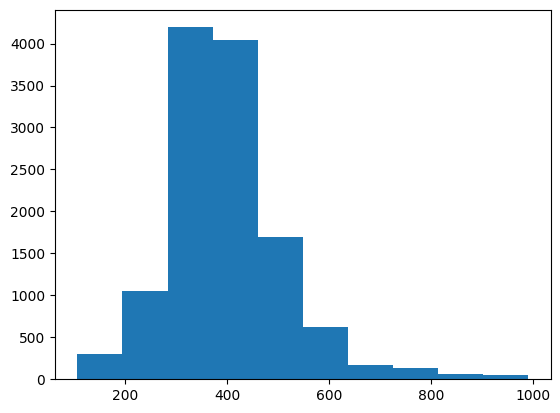

In [16]:
all_masses = [float(r["precursor_mz"]) for r in data_w_CE_Hplus]
plt.hist(all_masses)
plt.show() 

Group data by the molecular formula

In [ ]:
data_by_formula = {} 

for r in tqdm(data_w_CE_Hplus):

    formula = r["formula"]
    metadata = copy.deepcopy(r)
    metadata["ionmode"] = "positive"
    del metadata["mzs"]
    del metadata["intensities"]

    # Add in the fingerprint
    mol = Chem.MolFromSmiles(r["smiles"])
    
    metadata["maccs"] = get_MACCS(mol)

    metadata["morgan4_256"] = get_morgan(mol, 2, 256)
    metadata["morgan4_1024"] = get_morgan(mol, 2, 1024)
    metadata["morgan4_2048"] = get_morgan(mol, 2, 2048)
    metadata["morgan4_4096"] = get_morgan(mol, 2, 4096)

    metadata["morgan6_256"] = get_morgan(mol, 3, 256)
    metadata["morgan6_1024"] = get_morgan(mol, 3, 1024)
    metadata["morgan6_2048"] = get_morgan(mol, 3, 2048)
    metadata["morgan6_4096"] = get_morgan(mol, 3, 4096)

    mz = np.array([float(i) for i in r["mzs"].split(",")])
    intensities = np.array([float(i) for i in r["intensities"].split(",")])
    spec = Spectrum(mz = mz,
                    intensities = intensities,
                    metadata = metadata)

    if formula not in data_by_formula: data_by_formula[formula] = [] 

    data_by_formula[formula].append(spec)

  0%|          | 0/12332 [00:00<?, ?it/s]

100%|██████████| 12332/12332 [00:27<00:00, 445.26it/s]


Measure pairwise MS similarity of molecules with same molecular formula

In [18]:
data_by_formula_sieved = {k: data_by_formula[k] for k in dict(sorted(data_by_formula.items(), key = lambda x : len(x[1]), reverse = True)).keys() if len( data_by_formula[k]) >= 5}

In [26]:
pairwise_similarity_path = os.path.join(cache_folder, f"similarity_{most_common_energy}_{most_common_adduct}_{most_common_instrument}_massspec_gym.pkl")

if not os.path.exists(pairwise_similarity_path):

    pairwise_similarity = {} 

    for formula, spec_list in data_by_formula_sieved.items():

        if formula not in pairwise_similarity: pairwise_similarity[formula] = {}
        
        match = pairwise_match(spec_list)

        pairwise_cosine_similarity_score = unpack_scores(calculate_scores(spec_list, spec_list, greedy_cs, is_symmetric = True))
        pairwise_deepms_score = calculate_scores(spec_list, spec_list, ms2deepscore, is_symmetric = True).to_array()
        pairwise_maccs_score = np.array(pairwise_tanimoto_similarity(spec_list, "maccs"))
        pairwise_morgan4_256_score = np.array(pairwise_tanimoto_similarity(spec_list, "morgan4_256"))
        pairwise_morgan4_1024_score = np.array(pairwise_tanimoto_similarity(spec_list, "morgan4_1024"))
        pairwise_morgan4_2048_score = np.array(pairwise_tanimoto_similarity(spec_list, "morgan4_2048"))
        pairwise_morgan4_4096_score = np.array(pairwise_tanimoto_similarity(spec_list, "morgan4_4096"))

        pairwise_morgan6_256_score = np.array(pairwise_tanimoto_similarity(spec_list, "morgan6_256"))
        pairwise_morgan6_1024_score = np.array(pairwise_tanimoto_similarity(spec_list, "morgan6_1024"))
        pairwise_morgan6_2048_score = np.array(pairwise_tanimoto_similarity(spec_list, "morgan6_2048"))
        pairwise_morgan6_4096_score = np.array(pairwise_tanimoto_similarity(spec_list, "morgan6_4096"))

        pairwise_similarity[formula]["match"] = match
        pairwise_similarity[formula]["CS"] = pairwise_cosine_similarity_score
        pairwise_similarity[formula]["deepms"] = pairwise_deepms_score
        pairwise_similarity[formula]["maccs"] = pairwise_maccs_score
        pairwise_similarity[formula]["morgan4_256"] = pairwise_morgan4_256_score
        pairwise_similarity[formula]["morgan4_1024"] = pairwise_morgan4_1024_score
        pairwise_similarity[formula]["morgan4_2048"] = pairwise_morgan4_2048_score
        pairwise_similarity[formula]["morgan4_4096"] = pairwise_morgan4_4096_score
        pairwise_similarity[formula]["morgan6_256"] = pairwise_morgan6_256_score
        pairwise_similarity[formula]["morgan6_1024"] = pairwise_morgan6_1024_score
        pairwise_similarity[formula]["morgan6_2048"] = pairwise_morgan6_2048_score
        pairwise_similarity[formula]["morgan6_4096"] = pairwise_morgan6_4096_score

    pickle_data(pairwise_similarity, pairwise_similarity_path)

else:
    pairwise_similarity = load_pickle(pairwise_similarity_path)


17it [00:00, 27.95it/s]
12it [00:00, 140.50it/s]
10it [00:00, 140.97it/s]
10it [00:00, 145.29it/s]
9it [00:00, 144.08it/s]
9it [00:00, 153.45it/s]
9it [00:00, 154.70it/s]
8it [00:00, 147.17it/s]
8it [00:00, 151.87it/s]
8it [00:00, 152.71it/s]
8it [00:00, 148.97it/s]
8it [00:00, 137.90it/s]
8it [00:00, 135.94it/s]
7it [00:00, 137.85it/s]
7it [00:00, 138.45it/s]
7it [00:00, 137.32it/s]
7it [00:00, 140.24it/s]
7it [00:00, 137.35it/s]
7it [00:00, 138.39it/s]
7it [00:00, 139.91it/s]
7it [00:00, 140.80it/s]
7it [00:00, 140.80it/s]
7it [00:00, 135.46it/s]
7it [00:00, 137.32it/s]
7it [00:00, 141.40it/s]
7it [00:00, 139.15it/s]
7it [00:00, 148.81it/s]
7it [00:00, 145.14it/s]
7it [00:00, 138.98it/s]
7it [00:00, 141.42it/s]
7it [00:00, 135.94it/s]
7it [00:00, 136.07it/s]
7it [00:00, 140.27it/s]
7it [00:00, 136.36it/s]
7it [00:00, 140.24it/s]
7it [00:00, 141.14it/s]
6it [00:00, 244.11it/s]
6it [00:00, 137.13it/s]
6it [00:00, 139.55it/s]
6it [00:00, 137.68it/s]
6it [00:00, 135.07it/s]
6it [00:00, 1

Look at the score breakdown

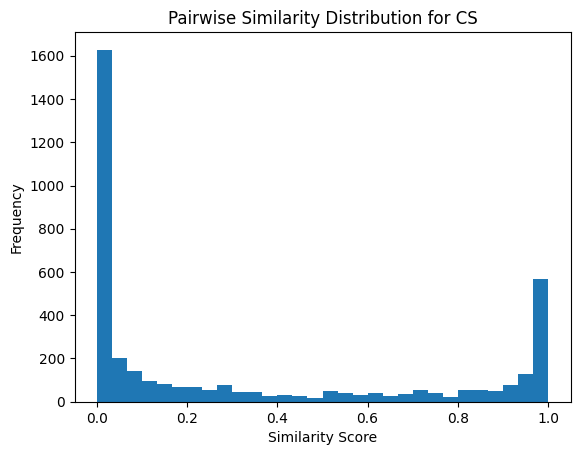

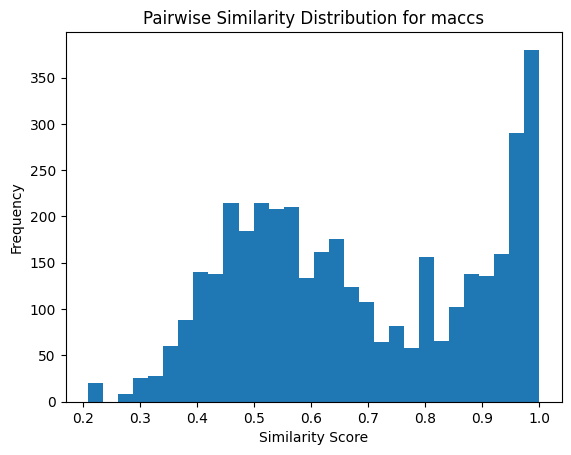

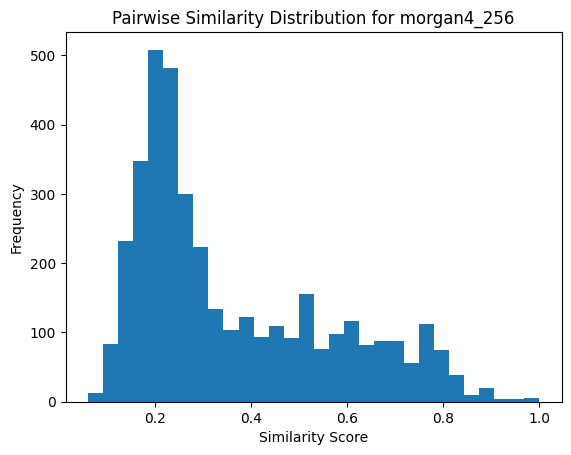

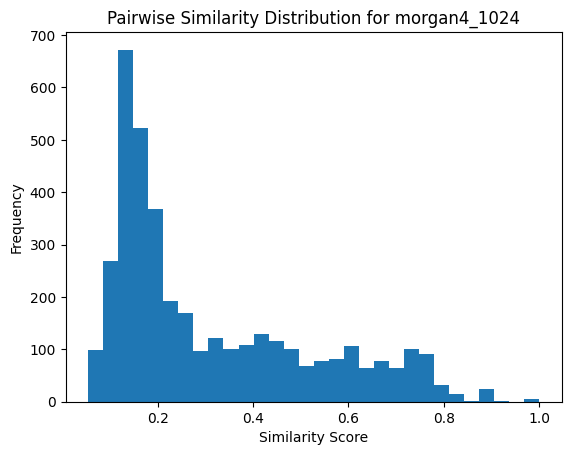

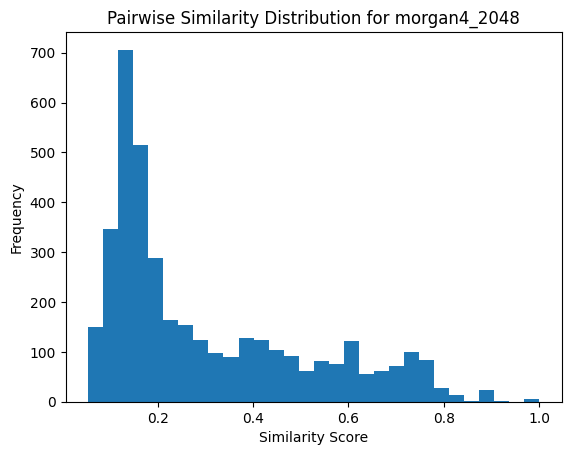

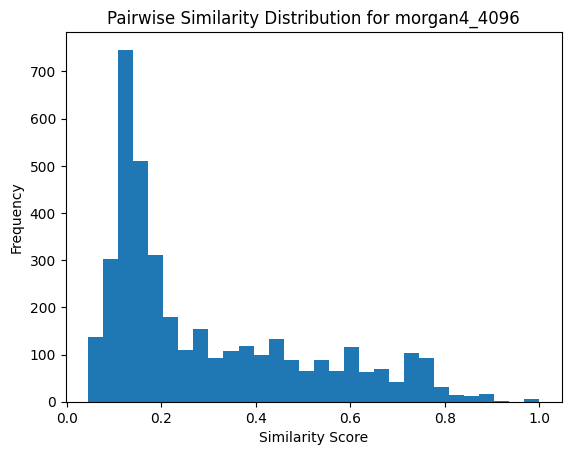

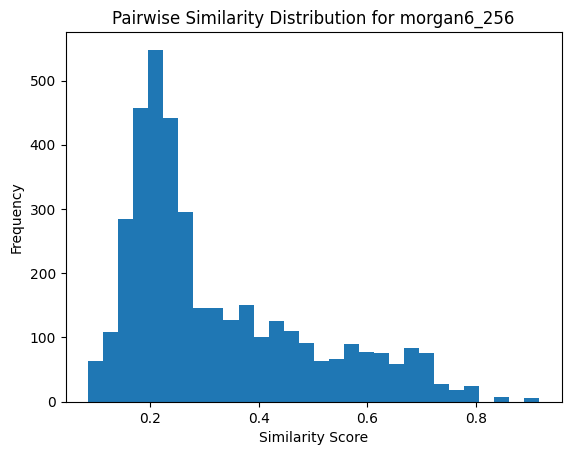

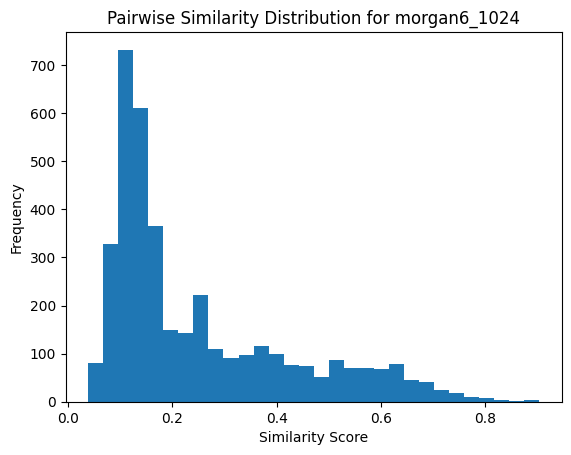

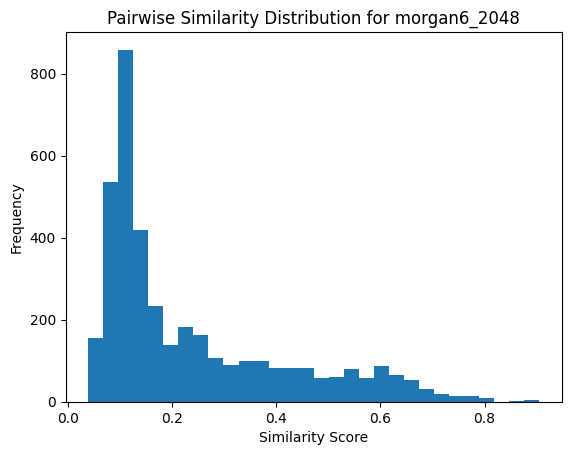

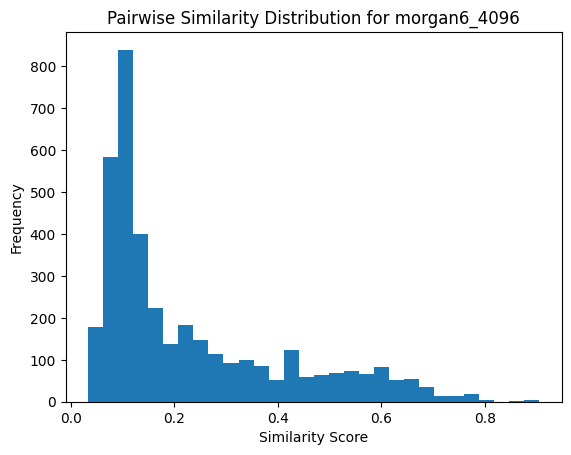

In [ ]:
for key in ["CS", "maccs", "morgan4_256", "morgan4_1024", "morgan4_2048", "morgan4_4096",
            "morgan6_256", "morgan6_1024", "morgan6_2048", "morgan6_4096"]:

    pairwise = []

    for k, f in pairwise_similarity.items():

        match = f["match"]
        score = np.array(f[key])

        score = score[match == 0]
        pairwise.extend(score)

    pairwise = np.array(pairwise)

    plt.hist(pairwise, bins=30)  # Adjust bins as needed
    plt.xlabel('Similarity Score')  # X-axis label
    plt.ylabel('Frequency')  # Y-axis label
    plt.title(f'Pairwise Similarity Distribution for {key}')  # Title for each histogram
    plt.show()